In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def convert_phq8_to_severity(phq8):
    if phq8 >= 0 and phq8 <= 4:
        return 0
    elif phq8 >= 5 and phq8 <= 9:
        return 1
    elif phq8 >= 10 and phq8 <= 14:
        return 2
    elif phq8 >= 15 and phq8 <= 19:
        return 3
    elif phq8 >= 20 and phq8 <= 24:
        return 4

def convert_phq8_to_diagnosis(phq8):
    if phq8 >= 0 and phq8 <= 4:
        return 0
    else:
        return 1

In [3]:
rootdir = "/data/users4/xli/ai-psychiatrist"
filepath = os.path.join(rootdir, "meta_review", "meta_review_test.csv")
pred_df = pd.read_csv(filepath)
pred_df.head(3)

,participant_id,response,diagnosis,severity,explanation
0,302,```xml\n<diagnosis>1</diagnosis>\n<severity>1<...,1,1,"\nBased on the interview transcript, qualitati..."
1,307,```xml\n<diagnosis>1</diagnosis>\n<severity>1<...,1,1,\nThe participant demonstrates several indicat...
2,316,```xml\n<diagnosis>1</diagnosis>\n<severity>2<...,1,2,\nThe participant clearly meets criteria for a...


In [4]:
dev_split_phq8 = pd.read_csv("/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/dev_split_Depression_AVEC2017.csv")
train_split_phq8 = pd.read_csv("/data/users4/xli/ai-psychiatrist/datasets/daic_woz_dataset/train_split_Depression_AVEC2017.csv")
merged_df = pd.concat([dev_split_phq8, train_split_phq8], ignore_index=True)
gt_df = merged_df.sort_values('Participant_ID').reset_index(drop=True)
gt_df.head(3)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,303,0,0,0,0,0,0,0,0,0,0,0
2,304,0,6,0,0,1,1,2,2,0,0,0


In [5]:
participant_id_list = pred_df["participant_id"].tolist()
participant_id_list.sort()

gt_severity_list = []
gt_diagnosis_list = []
pred_severity_list = []
pred_diagnosis_list = []

for id in participant_id_list:
    gt_phq = gt_df.loc[gt_df['Participant_ID'] == id, 'PHQ8_Score'].iloc[0]
    gt_severity = convert_phq8_to_severity(gt_phq)
    gt_diagnosis = convert_phq8_to_diagnosis(gt_phq)
    pred_severity = pred_df.loc[pred_df['participant_id'] == id, 'severity'].iloc[0]
    pred_diagnosis = pred_df.loc[pred_df['participant_id'] == id, 'diagnosis'].iloc[0]
    gt_severity_list.append(gt_severity)
    gt_diagnosis_list.append(gt_diagnosis)
    pred_severity_list.append(pred_severity)
    pred_diagnosis_list.append(pred_diagnosis)

In [6]:
cm_severity = confusion_matrix(gt_severity_list, pred_severity_list, labels=[0, 1, 2, 3, 4])
cm_diagnosis = confusion_matrix(gt_diagnosis_list, pred_diagnosis_list, labels=[0, 1])

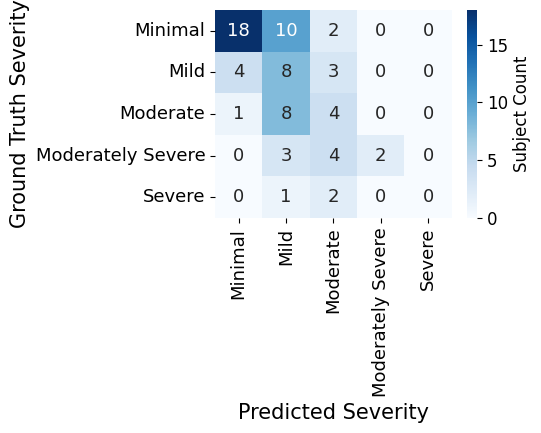

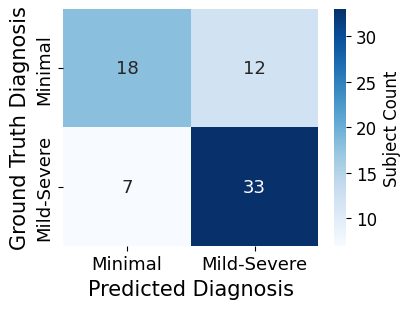

In [7]:
severity_labels = ["Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]
diagnosis_labels = ["Minimal", "Mild-Severe"]
label_fontsize = 15
tick_fontsize = 13
colorbar_fontsize = 12

fig, ax = plt.subplots(1, 1, figsize=(5.4, 4.5))

sns.heatmap(cm_severity, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=severity_labels, 
            yticklabels=severity_labels,
            ax=ax,
            annot_kws={'size': tick_fontsize})
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Subject Count', size=colorbar_fontsize)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Predicted Severity', fontsize=label_fontsize)
ax.set_ylabel('Ground Truth Severity', fontsize=label_fontsize)

plt.tight_layout()
plt.savefig("confusion_matrix_severity.pdf")

fig, ax = plt.subplots(1, 1, figsize=(4.2, 3.2))

sns.heatmap(cm_diagnosis, annot=True, 
            fmt='d', cmap='Blues', 
            xticklabels=diagnosis_labels, 
            yticklabels=diagnosis_labels,
            ax=ax,
            annot_kws={'size': tick_fontsize})
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Subject Count', size=colorbar_fontsize)
cbar.ax.tick_params(labelsize=colorbar_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax.set_xlabel('Predicted Diagnosis', fontsize=label_fontsize)
ax.set_ylabel('Ground Truth Diagnosis', fontsize=label_fontsize)

plt.tight_layout()
plt.savefig("confusion_matrix_diagnosis.pdf")